<a href="https://colab.research.google.com/github/wendelpires1976/mercado_de_capitais/blob/main/An%C3%A1lise_2_Trade_Quantitativo_Escolhendo_a_Estrat%C3%A9gia_%C3%93tima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [38]:
#@title Rodar no colab para instalar pacotes necessários {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
# Run This Cell for Colab
# Just instaling the required packages

!pip install yfinance
!pip install vectorbt
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
import vectorbt as vbt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Definindo parâmetros

In [58]:
# Análise de um Ativo Americano
codigo = 'BTC-USD'
ativos_comparacao = [codigo, 'ETH-USD', 'ADA-USD']

data_inicial = '2017-01-01'  
data_final = '2018-01-01'

# Os preços de fechamentos dos ativos
vbt.YFData.download(ativos_comparacao, start=data_inicial, end=data_final).get('Close')

symbol,BTC-USD,ETH-USD,ADA-USD
Date,,,
2017-01-01 00:00:00+00:00,998.325012,NaN,NaN
2017-01-02 00:00:00+00:00,1021.750000,NaN,NaN
2017-01-03 00:00:00+00:00,1043.839966,NaN,NaN
2017-01-04 00:00:00+00:00,1154.729980,NaN,NaN
2017-01-05 00:00:00+00:00,1013.380005,NaN,NaN
...,...,...,...
2017-12-27 00:00:00+00:00,15838.500000,762.841980,0.414176
2017-12-28 00:00:00+00:00,14606.500000,737.023010,0.407701
2017-12-29 00:00:00+00:00,14656.200195,753.591980,0.529299


## Baixando os dados

In [59]:
precos = vbt.YFData.download(codigo, start=data_inicial, end=data_final).get()
fechamento = vbt.YFData.download(codigo, start=data_inicial, end=data_final).get('Close')

# Parte I - Analisando a Série

In [60]:
fechamento.vbt.plot().show()

In [61]:
precos.vbt.ohlcv.plot().show()

## Gráfico comparativo

Com investimento inicial de \$1 (ou R\$ 1)

In [62]:
vbt.YFData.download(ativos_comparacao,
                    start=data_inicial,
                    end=data_final).plot(column='Close', base=1).show()

## Gráfico Quant Stat

Retorno Cumulativo, Drawdown e Retorno Diário

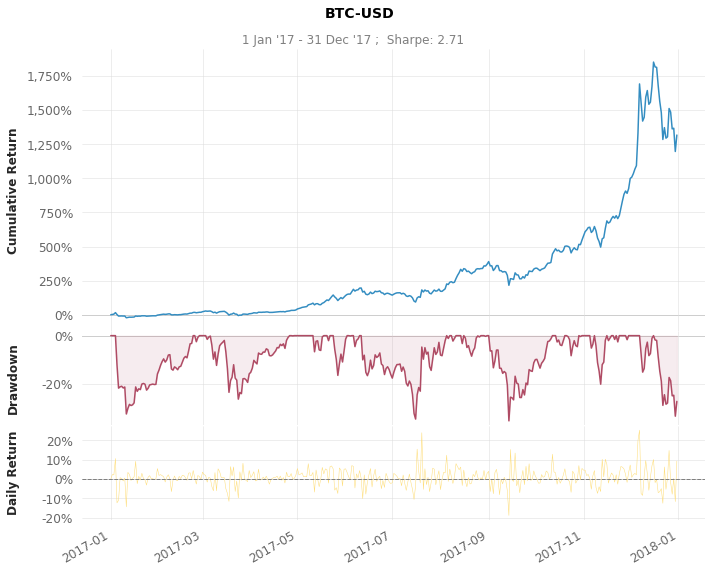

In [63]:
warnings.filterwarnings('ignore')

retornos = fechamento.vbt.to_returns()
retornos.vbt.returns.qs.plot_snapshot(title=codigo)

# Analisando Estratégias de Trade

## Média Móvel Simples (SMA)

SMA: Simple Moving Averages

In [64]:
n_periodos_curta = 20
n_periodos_longa = 50

media_curta = vbt.MA.run(fechamento, n_periodos_curta, short_name='media_curta')
media_longa = vbt.MA.run(fechamento, n_periodos_longa, short_name='media_longa')

fig = fechamento.vbt.plot(trace_kwargs=dict(name='Preço de Fechamento'))
media_curta.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Curta'), fig=fig)
media_longa.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Longa'), fig=fig)

fig.show()

## Índice de Força Relativa (RSI)

RSI: Relative Strength Index

In [65]:
rsi = vbt.RSI.run(fechamento)
rsi.plot().show()

## Estocástico (Stochastics)

In [66]:
vbt.STOCH.run(precos['High'], precos['Low'], precos['Close']).plot().show()

## Bandas de Bolinger (Bollinger Bands)

In [67]:
vbt.BBANDS.run(fechamento).plot().show()

# Parte II - Escolhendo Melhor Estratégia

## Testando manualmente

### Teste dentro da amostra (in-sample)

In [68]:
estrategia_media_movel_curta = 10
estrategia_media_movel_longa = 30

media_movel_curta = vbt.MA.run(fechamento, estrategia_media_movel_curta, short_name='fast_ma')
media_movel_longa = vbt.MA.run(fechamento, estrategia_media_movel_longa, short_name='slow_ma')

entradas = media_movel_curta.ma_crossed_above(media_movel_longa)
saidas = media_movel_curta.ma_crossed_below(media_movel_longa)

# Create the Signals Portfolio
pf = vbt.Portfolio.from_signals(fechamento,
                                entries=entradas,
                                exits=saidas,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

print("Retorno Total (%):", round(pf.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf.sharpe_ratio(),2)) # Entenda IS em https://pt.wikipedia.org/wiki/%C3%8Dndice_de_Sharpe

Retorno Total (%): 1015.85
Retorno Anualizado (%): 1015.85
Índice Sharpe: 3.74


In [69]:
# print(pf.stats()) # Todas as estatisticas do Portfolio

In [70]:
# print(pf.returns_stats()) # Todas as estatisticas do retorno

In [71]:
# Gráfico da Estratégia
fig = pf.close.vbt.plot(trace_kwargs=dict(name='Preço de Fechamento'))
media_movel_curta.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Curta'), fig=fig)
media_movel_longa.ma.vbt.plot(trace_kwargs=dict(name='Média Móvel Longa'), fig=fig)
pf.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)
fig.show()

In [72]:
# Mostrar as ordens
# pf.orders.records_readable

In [73]:
# Gráfico de Saldo em Caixa e valor dos Ativos investidos
# pf.plot(subplots=['cash', 'assets', 'value']).show()

### Analisar Fora da Amostra (out-of-sample)

In [74]:
# Baixar dados fora da amostra
data_inicial2 = data_final 
data_final2 = '2019-01-01'
precos2 = vbt.YFData.download(codigo, start=data_inicial2, end=data_final2).get()
fechamento2 = vbt.YFData.download(codigo, start=data_inicial2, end=data_final2).get('Close')
print(precos2)

                                   Open          High           Low  \
Date                                                                  
2018-01-01 00:00:00+00:00  14112.200195  14112.200195  13154.700195   
2018-01-02 00:00:00+00:00  13625.000000  15444.599609  13163.599609   
2018-01-03 00:00:00+00:00  14978.200195  15572.799805  14844.500000   
2018-01-04 00:00:00+00:00  15270.700195  15739.700195  14522.200195   
2018-01-05 00:00:00+00:00  15477.200195  17705.199219  15202.799805   
...                                 ...           ...           ...   
2018-12-27 00:00:00+00:00   3854.688477   3874.416992   3645.448486   
2018-12-28 00:00:00+00:00   3653.131836   3956.135986   3642.632080   
2018-12-29 00:00:00+00:00   3932.491699   3963.758789   3820.408691   
2018-12-30 00:00:00+00:00   3822.384766   3901.908936   3797.219238   
2018-12-31 00:00:00+00:00   3866.839111   3868.742920   3725.867432   

                                  Close       Volume  Dividends  Stock Split

In [75]:
# Testar estratégia fora da amostra
media_movel_curta2 = vbt.MA.run(fechamento2, estrategia_media_movel_curta, short_name='fast_ma')
media_movel_longa2 = vbt.MA.run(fechamento2, estrategia_media_movel_longa, short_name='slow_ma')

entradas2 = media_movel_curta2.ma_crossed_above(media_movel_longa2)
saidas2 = media_movel_curta2.ma_crossed_below(media_movel_longa2)

# Create the Signals Portfolio
pf2 = vbt.Portfolio.from_signals(fechamento2,
                                entries=entradas2,
                                exits=saidas2,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

In [84]:
# Comparar desempenho
print("=" * 70,"\n")
print("RESULTADO NA AMOSTRA DE TESTE (in-sample)\n")
print("Retorno Total (%):", round(pf.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf.sharpe_ratio(),2))
print("=" * 70,"\n")
print("RESULTADO FORA DA AMOSTRA (out-of-sample)\n")
print("Retorno Total (%):", round(pf2.total_return() * 100,2))
print("Retorno Anualizado (%):", round(pf2.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf2.sharpe_ratio(),2))
print("=" * 70)


RESULTADO NA AMOSTRA DE TESTE (in-sample)

Retorno Total (%): 1015.85
Retorno Anualizado (%): 1015.85
Índice Sharpe: 3.74

RESULTADO FORA DA AMOSTRA (out-of-sample)

Retorno Total (%): -41.35
Retorno Anualizado (%): -41.35
Índice Sharpe: -1.16


### Comentário

(O Índice sharpe teve um resultado muito acima da média 3,74 na estratégia no ano de 2017, porém no ano de 2018 a mesma estratégia teve um resultado negativo, -1,16. por se tratar de cryptomoeda e ainda não ter uma regulamentação específica, muitos fatores especulativos influenciam demasiadamente no valor dos ativos )

## Otimizando computacionalmente

### Escolher janela de teste

In [77]:
# Definir intervalo de janelas
janelas = np.arange(10, 50)
print(janelas)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]


In [85]:
fechamento

Date
2017-01-01 00:00:00+00:00      998.325012
2017-01-02 00:00:00+00:00     1021.750000
2017-01-03 00:00:00+00:00     1043.839966
2017-01-04 00:00:00+00:00     1154.729980
2017-01-05 00:00:00+00:00     1013.380005
                                 ...     
2017-12-27 00:00:00+00:00    15838.500000
2017-12-28 00:00:00+00:00    14606.500000
2017-12-29 00:00:00+00:00    14656.200195
2017-12-30 00:00:00+00:00    12952.200195
2017-12-31 00:00:00+00:00    14156.400391
Freq: D, Name: Close, Length: 365, dtype: float64

In [86]:
# Testar automaticamente diversas combinações de janelas
# fast_ma, slow_ma = vbt.MA.run_combs(price, windows)
media_movel_curta3, media_movel_longa3 = vbt.MA.run_combs(fechamento, janelas)

# entries = fast_ma.ma_crossed_above(slow_ma)
# exits = fast_ma.ma_crossed_below(slow_ma)
entradas3 = media_movel_curta3.ma_crossed_above(media_movel_longa3)
saidas3 = media_movel_curta3.ma_crossed_below(media_movel_longa3)

# portfolio = vbt.Portfolio.from_signals(price, entries, exits, freq='1d', direction='both')
# Create the Signals Portfolio
pf3 = vbt.Portfolio.from_signals(fechamento,
                                entries=entradas3,
                                exits=saidas3,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

### Resultado in-sample

In [87]:
# print("Retorno Total (%):\n\n", round(pf3.total_return().sort_values() * 100,2))
# print("Retorno Anualizado (%):\n\n", round(pf3.annualized_return().sort_values() * 100,2))
print("Índice Sharpe:\n\n", round(pf3.sharpe_ratio().sort_values(),2))

Índice Sharpe:

 ma_1_window  ma_2_window
29           30             2.07
41           43             2.16
40           44             2.16
41           44             2.19
40           46             2.19
                            ... 
10           23             4.31
12           17             4.32
11           22             4.38
10           22             4.42
             21             4.51
Name: sharpe_ratio, Length: 780, dtype: float64


### Testar fora da amostra (out-of-sample)

Testando a melhor estratégia encontrada na etapa anterior (atulizar números com as melhores janelas).

### A FAZER: Colocar manualmente a melhor estrategia

In [88]:
estrategia_otima_media_movel_curta = 10
estrategia_otima_media_movel_longa = 21

In [89]:
# Rodar teste
media_movel_curta4 = vbt.MA.run(fechamento2, estrategia_otima_media_movel_curta, short_name='fast_ma')
media_movel_longa4 = vbt.MA.run(fechamento2, estrategia_otima_media_movel_longa, short_name='slow_ma')

entradas4 = media_movel_curta4.ma_crossed_above(media_movel_longa4)
saidas4 = media_movel_curta4.ma_crossed_below(media_movel_longa4)

# Create the Signals Portfolio
pf4 = vbt.Portfolio.from_signals(fechamento2,
                                entries=entradas4,
                                exits=saidas4,
                                freq="D",
                                # init_cash=100_000,
                                fees=0.0025,
                                slippage=0.0025)

### Analisar Resultados (out-of-sample)

In [90]:
# Comparar desempenho
print("=" * 70,"\n")
print("RESULTADO NA AMOSTRA DE TESTE (in-sample)\n")
#print("Retorno Total (%):", round(float(pf3.total_return().sort_values().tail(1).values) * 100,2))
#print("Retorno Anualizado (%):", round(float(pf3.annualized_return().sort_values().tail(1).values) * 100,2))
print("Índice Sharpe:", round(float(pf3.sharpe_ratio().sort_values().tail(1).values),2))
print("=" * 70,"\n")
print("RESULTADO FORA DA AMOSTRA (out-of-sample)\n")
#print("Retorno Total (%):", round(pf4.total_return() * 100,2))
#print("Retorno Anualizado (%):", round(pf4.annualized_return() * 100,2))
print("Índice Sharpe:", round(pf4.sharpe_ratio(),2))
print("=" * 70)


RESULTADO NA AMOSTRA DE TESTE (in-sample)

Índice Sharpe: 4.51

RESULTADO FORA DA AMOSTRA (out-of-sample)

Índice Sharpe: -0.85


### COMENTÁRIO: 

( Não funcinou, usando o computudor diminuiu o perda, mas ainda assim é preciso utilizar mais dados de anos anteriores e treinar mais o computador para tentar diminuir o erro)

# Próximo tópico:

Treino, validação e teste.

<img src="https://vectorbt.dev/assets/images/features_rolling_split.svg">
